In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

Step 0: load our data

In [ ]:
# Load data
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/MSc thesis/processed_data/metadata/fully_concatenated_data.csv", lineterminator='\n')

In [ ]:
# List of image and text feature columns to keep
image_columns = [f'image_{i}' for i in range(0, 2049)]
text_columns = [f'text_{i}' for i in range(0, 768)]

# Additional columns you want to keep
additional_columns_to_keep = ['like_count', 'comment_count', 'post_id', 'Followers', 'Username', 'Is_English', 'Image_Count']

# Combine both lists of columns to keep
columns_to_keep = image_columns + additional_columns_to_keep + text_columns

# Drop all columns except those specified in columns_to_keep
columns_to_drop = [col for col in data.columns if col not in columns_to_keep]

# Drop the unwanted columns from the dataframe
data_2 = data.drop(columns=columns_to_drop)


# Maybe don't delete category and detected languages
# Same with comments disabled and video
# potential columns to add or not:
#'comments_disabled',
#'is_video'
# Category
data_2.head(10)

# Filter image count to 10 or less, which is what is realistic in the industry
data_2 = data_2[data_2['Image_Count'] <= 1]

In [ ]:
# Filter the DataFrame to keep only observations where 'Is_English' is True
data_2 = data_2[data_2['Is_English'] == True]

Step 1: group and split the data by post_id

Define a popularity variable

In [ ]:
# Set the engagement rate variable
data_2['popularity'] = (((data_2['like_count'] + data_2['comment_count'])/data_2['Followers']))

<ipython-input-6-747e2ff0d805>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2['popularity'] = (((data_2['like_count'] + data_2['comment_count'])/data_2['Followers']))


Let's split the data!

In [ ]:
# Define the number of iterations and an array to store accuracies
n_iterations = 4
accuracies = []

for seed in range(n_iterations):
    print(f"Iteration {seed+1}")

    # Split users into training and temporary sets with a new seed each time
    train_users, temp_users = train_test_split(data_2['Username'].unique(), test_size=0.2, random_state=seed)
    val_users, test_users = train_test_split(temp_users, test_size=0.5, random_state=seed)

    # Assign posts to training, validation, and test sets
    train_data = data_2[data_2['Username'].isin(train_users)]
    val_data = data_2[data_2['Username'].isin(val_users)]
    test_data = data_2[data_2['Username'].isin(test_users)]

    # Calculate the median popularity rate for each dataset
    median_popularity_rate_train = train_data['popularity'].quantile(0.5)
    train_data.loc[:, 'popularity'] = (train_data['popularity'] > median_popularity_rate_train).astype(int)
    median_popularity_rate_val = val_data['popularity'].quantile(0.5)
    val_data.loc[:, 'popularity'] = (val_data['popularity'] > median_popularity_rate_val).astype(int)
    median_popularity_rate_test = test_data['popularity'].quantile(0.5)
    test_data.loc[:, 'popularity'] = (test_data['popularity'] > median_popularity_rate_test).astype(int)

    # Prepare data for XGBoost
    X_train = train_data.drop(['popularity', 'post_id', 'like_count', 'comment_count', 'Username', 'Image_Count', 'Followers', 'Is_English'], axis=1)
    y_train = train_data['popularity']
    X_val = val_data.drop(['popularity', 'post_id', 'like_count', 'comment_count', 'Username', 'Image_Count', 'Followers', 'Is_English'], axis=1)
    y_val = val_data['popularity']
    X_test = test_data.drop(['popularity', 'post_id', 'like_count', 'comment_count', 'Username', 'Image_Count', 'Followers', 'Is_English'], axis=1)
    y_test = test_data['popularity']

    # Create the model
    model_b = Sequential()

    # Assume X_train is your training data loaded previously with correct dimensions
    # Add new layers
    model_b.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
    model_b.add(Dropout(0.5))
    model_b.add(Dense(32, activation='relu'))
    model_b.add(Dense(1, activation='sigmoid'))

    # Initialize the Adam optimizer with a specific learning rate
    optimizer = Adam(learning_rate=0.001)

    #Compiling the model
    model_b.compile(optimizer= optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

    # Set up early stopping
    early_stopping = EarlyStopping(monitor = 'val_accuracy',
                               patience = 20,
                               restore_best_weights = True)
    # Fit the model
    history = model_b.fit(X_train,
                      y_train,
                      epochs=500,
                      batch_size=128,
                      validation_data = (X_val, y_val),
                      callbacks=[early_stopping])

    test_loss, test_acc = model_b.evaluate(X_test, y_test)

    # Evaluate the model on the test set
    y_pred_prob = model_b.predict(X_test)
    y_pred_binary = (y_pred_prob > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred_binary)
    accuracies.append(accuracy)

    print(f"Accuracy for iteration {seed+1}: {accuracy:.2f}")

# Calculate the average accuracy across all iterations
average_accuracy = np.mean(accuracies)
print(f"Average Accuracy across {n_iterations} iterations: {average_accuracy:.2f}")

Iteration 1
Epoch 1/500
706/706 [==============================] - 7s 5ms/step - loss: 0.6901 - accuracy: 0.5333 - val_loss: 0.6830 - val_accuracy: 0.5674
Epoch 2/500
706/706 [==============================] - 3s 4ms/step - loss: 0.6821 - accuracy: 0.5511 - val_loss: 0.6770 - val_accuracy: 0.5706
Epoch 3/500
706/706 [==============================] - 3s 4ms/step - loss: 0.6788 - accuracy: 0.5585 - val_loss: 0.6772 - val_accuracy: 0.5717
Epoch 4/500
706/706 [==============================] - 3s 4ms/step - loss: 0.6770 - accuracy: 0.5623 - val_loss: 0.6744 - val_accuracy: 0.5722
Epoch 5/500
706/706 [==============================] - 3s 4ms/step - loss: 0.6748 - accuracy: 0.5685 - val_loss: 0.6779 - val_accuracy: 0.5810
Epoch 6/500
706/706 [==============================] - 3s 4ms/step - loss: 0.6731 - accuracy: 0.5706 - val_loss: 0.6762 - val_accuracy: 0.5767
Epoch 7/500
706/706 [==============================] - 3s 4ms/step - loss: 0.6713 - accuracy: 0.5736 - val_loss: 0.6727 - val_accu

In [ ]:
# Alternatively, using numpy to generate bootstrap samples and calculate the percentiles
# Determine the size of the accuracies array
n = len(accuracies)
bootstrap_samples = np.random.choice(accuracies, (10000, n), replace=True)
ci_lower = np.percentile(bootstrap_samples, 2.5)
ci_upper = np.percentile(bootstrap_samples, 97.5)

print(f"Bootstrap 95% Confidence Interval: {ci_lower:.5f} - {ci_upper:.5f}")

Bootstrap 95% Confidence Interval: 0.58690 - 0.59330


350/350 [==============================] - 1s 2ms/step


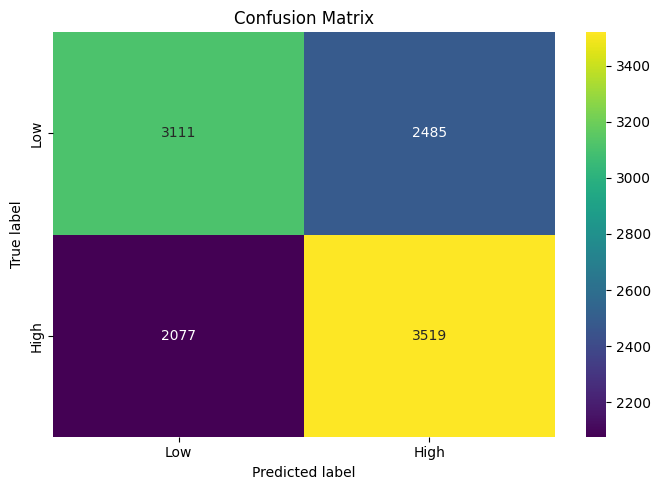

              precision    recall  f1-score   support

         Low       0.60      0.56      0.58      5596
        High       0.59      0.63      0.61      5596

    accuracy                           0.59     11192
   macro avg       0.59      0.59      0.59     11192
weighted avg       0.59      0.59      0.59     11192



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, X_test, y_test, type_of_model):
    # Predicting the probabilities for the test set
    y_pred_prob = model.predict(X_test)
    # Convert probabilities to binary labels
    y_pred = (y_pred_prob > 0.5).astype(int)

    # y_test should already be binary labels
    y_true = y_test.astype(int)

    # Generating the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Generating the classification report
    clr = classification_report(y_true, y_pred, target_names=['Low', 'High'])

    # Plotting the confusion matrix
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    # Show plot
    plt.show()

    # Print the classification report
    print(clr)

# Example usage
evaluate_model(model_b, X_val, val_data['popularity'], 'LightGBM')


354/354 [==============================] - 1s 2ms/step


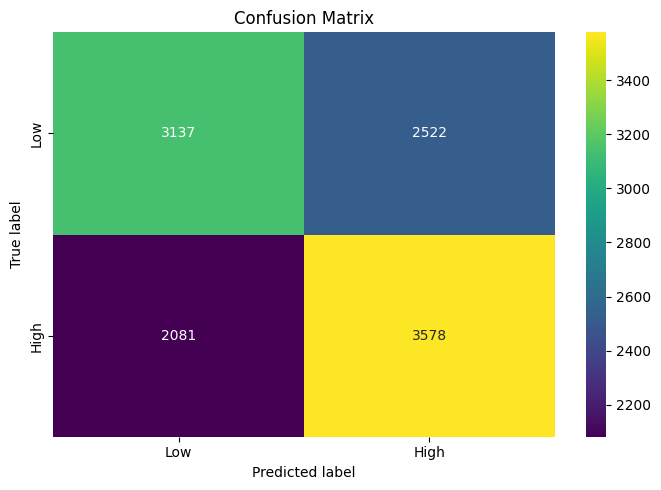

              precision    recall  f1-score   support

         Low       0.60      0.55      0.58      5659
        High       0.59      0.63      0.61      5659

    accuracy                           0.59     11318
   macro avg       0.59      0.59      0.59     11318
weighted avg       0.59      0.59      0.59     11318



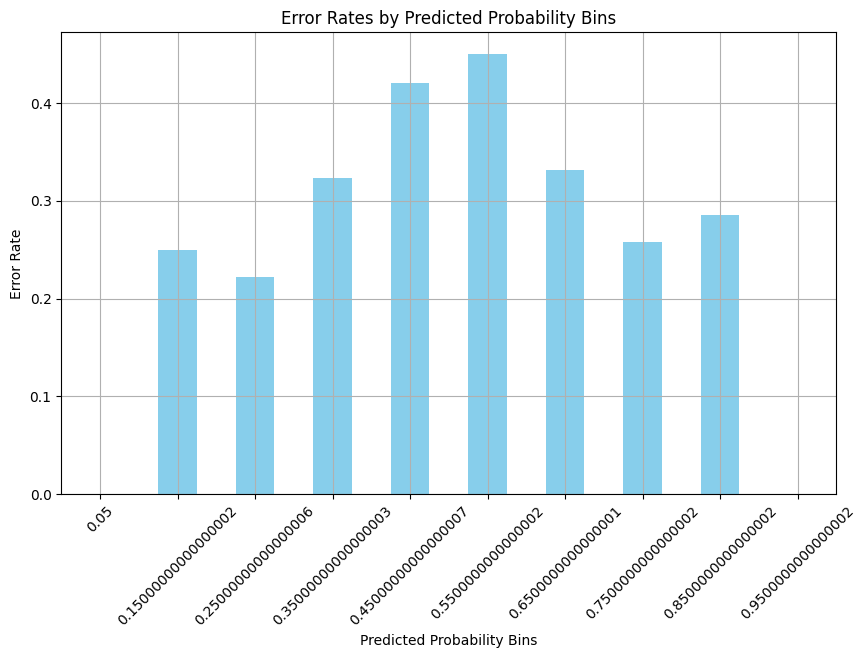

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model_and_error_rates(model, X_test, y_test):
    # Predicting the probabilities for the test set
    y_pred_prob = model.predict(X_test).flatten()

    # Convert probabilities to binary labels
    y_pred = (y_pred_prob > 0.5).astype(int)

    # y_test should already be binary labels
    y_true = y_test.astype(int)

    # Generating the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Generating the classification report
    clr = classification_report(y_true, y_pred, target_names=['Low', 'High'])

    # Plotting the confusion matrix
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

    # Print the classification report
    print(clr)

    # Calculate error rates by probability bins
    results = pd.DataFrame({
        'y_true': y_true,
        'y_pred_prob': y_pred_prob
    })

    results['prob_bin'] = pd.cut(results['y_pred_prob'], bins=np.arange(0, 1.1, 0.1), labels=np.arange(0.05, 1.05, 0.1))

    # Calculate error rates
    error_rates = results.groupby('prob_bin').apply(
        lambda x: np.mean(x['y_true'] != (x['y_pred_prob'] > 0.5))
    )

    # Plotting error rates by predicted probability bins
    plt.figure(figsize=(10, 6))
    error_rates.plot(kind='bar', color='skyblue')
    plt.title('Error Rates by Predicted Probability Bins')
    plt.xlabel('Predicted Probability Bins')
    plt.ylabel('Error Rate')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

# Example usage
evaluate_model_and_error_rates(model_b, X_test, test_data['popularity'])